# Assignment - 2
# Prakhar Jain
# 2022121008

Data preparation and rules
Please use the images of the MNIST hand-written digits recognition dataset. You may use torchvision.datasets
library to obtain the images and splits. You should have 60,000 training images and 10,000 test images. Use test
images only to evaluate your model performance.

## Q1: SIFT-BoVW-SVM [4 points]

1. [2 points] Implement the SIFT detector and descriptor. Compute cluster centers for the Bag-of-Visual-Words
approach. Represent the images as histograms (of visual words) and train a linear SVM model for 10-way
classification.

Note 1: You may want to use libraries such as cv2 (OpenCV) and sklearn (Sci-kit learn) for doing this question.
https://scikit-learn.org/stable/modules/svm.html#multi-class-classification may be useful for the
SVM.

Note 2: Seed random numbers for reproducibility (running the notebook again should give you the same results!).

2. [1 point] Keeping everything else constant, plot how classification accuracy changes as you sweep across 6 different
values for the number of clusters. Please decide what numbers are meaningful for this question. Explain the
trends in classification accuracy that you observe.

Note 1: It is recommended to try hyperparameters in logarithmic steps such as 2x or 3x multiples. An example
of 2x multiples is: 1, 2, 5, 10, 20, ... An example of 3x multiples is: 1, 3, 10, 30, 100, ...

3. [1 point] Show the results for 6 different hyperparameter settings. You may play with the SIFT detector or
descriptor and the linear SVM. Keep the number of clusters constant based on the answer to the previous
question. Explain the trends in classification accuracy that you observe.

In [42]:
DATASET_PATH = "MNIST"

DEBUG = False

In [43]:
import cv2
import numpy as np
from sklearn.cluster import KMeans #, MiniBatchKMeans
from sklearn import svm
from sklearn.model_selection import train_test_split
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class SIFT_SVM_Classifier:
    def __init__(self, dataset_path, n_clusters=8, sift_features=0, svm_c=1.0, svm_kernel='linear'):
        self.dataset_path = dataset_path
        self.n_clusters = n_clusters
        self.sift_features = sift_features  # New SIFT parameter
        self.svm_c = svm_c  # New SVM parameter for regularization strength
        self.svm_kernel = svm_kernel  # New SVM parameter for kernel type
        self.kmeans = None
        self.clf = svm.SVC(kernel=self.svm_kernel, C=self.svm_c, decision_function_shape='ovr', random_state=42)
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
        ])
        
    def load_data(self):
        dataset = datasets.MNIST(self.dataset_path, download=True, transform=self.transform)
        dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
        return dataloader
    
    def extract_sift_features(self, image):
        sift = cv2.SIFT_create(nfeatures=self.sift_features)
        keypoints, descriptors = sift.detectAndCompute(image, None)
        return descriptors
    
    def compute_kmeans(self, sift_features):
        # self.kmeans = MiniBatchKMeans(n_clusters=self.n_clusters, random_state=42)
        self.kmeans = KMeans(n_clusters=self.n_clusters, n_init=10, random_state=42)
        self.kmeans.fit(np.concatenate(sift_features))
    
    def image_to_histogram(self, descriptors):
        histogram = np.zeros(self.n_clusters)
        if descriptors is not None:
            predicted_labels = self.kmeans.predict(descriptors)
            for label in predicted_labels:
                histogram[label] += 1
        return histogram
    
    def prepare_features(self, dataloader):
        sift_features = []
        labels = []
        for images, label in dataloader:
            if DEBUG:
                print(images.shape)
            
            image = images.squeeze().numpy() * 255
            
            if DEBUG:
                print(image.shape)
            
            image = image.astype(np.uint8)
            
            if DEBUG:
                plt.imshow(image)
                plt.show()
            
            descriptors = self.extract_sift_features(image)
            if descriptors is not None:
                sift_features.append(descriptors)
                labels.append(label.item())

            # For debugging purposes
            if DEBUG and len(sift_features) != 0:
                print(f'Processed {len(sift_features)} images')

        
        self.compute_kmeans(sift_features)
        histograms = [self.image_to_histogram(feat) for feat in sift_features]
        return histograms, labels
    
    def train(self, X_train, y_train):
        self.clf.fit(X_train, y_train)
    
    def test(self, X_test, y_test):
        return self.clf.score(X_test, y_test)
    
    def run(self):
        dataloader = self.load_data()
        histograms, labels = self.prepare_features(dataloader)
        X_train, X_test, y_train, y_test = train_test_split(histograms, labels, test_size=0.2, random_state=42)
        self.train(X_train, y_train)
        accuracy = self.test(X_test, y_test)
        print('Accuracy:', accuracy)
        return accuracy


Running with 5 clusters


Accuracy: 0.3322814498933902
Accuracy with 5 clusters: 0.3322814498933902
Running with 10 clusters


Accuracy: 0.415863539445629
Accuracy with 10 clusters: 0.415863539445629
Running with 20 clusters


Accuracy: 0.5333049040511727
Accuracy with 20 clusters: 0.5333049040511727
Running with 40 clusters


Accuracy: 0.6344562899786781
Accuracy with 40 clusters: 0.6344562899786781
Running with 80 clusters


Accuracy: 0.7295522388059702
Accuracy with 80 clusters: 0.7295522388059702
Running with 160 clusters


Accuracy: 0.7922388059701493
Accuracy with 160 clusters: 0.7922388059701493


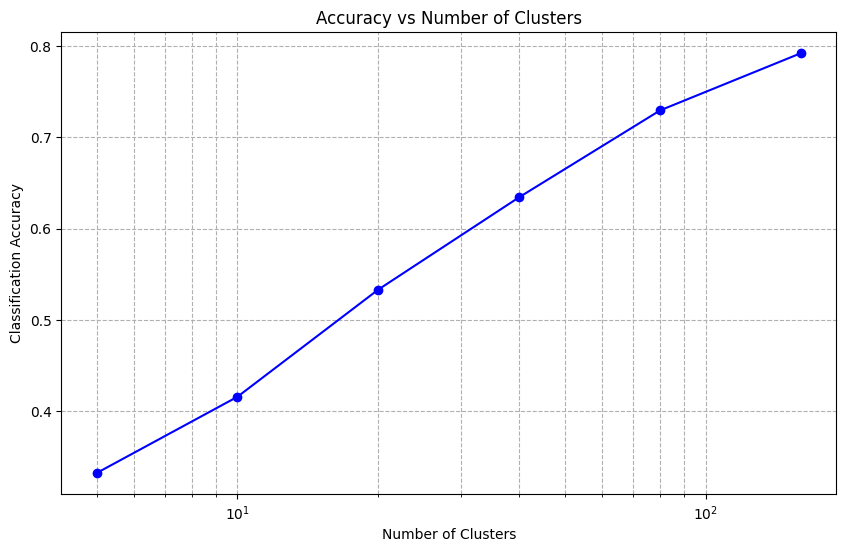

Best accuracy: (160, 0.7922388059701493)


In [44]:
def experiment_with_clusters(dataset_path):
    n_clusters_options = [5, 10, 20, 40, 80, 160]
    accuracies = []

    for n_clusters in n_clusters_options:
        print(f"Running with {n_clusters}")
        classifier = SIFT_SVM_Classifier(dataset_path, n_clusters=n_clusters)
        accuracy = classifier.run()
        accuracies.append((n_clusters, accuracy))
        print(f"Accuracy with {n_clusters} clusters: {accuracy}")

    # Plotting the results
    plt.figure(figsize=(10, 6))
    clusters, accs = zip(*accuracies)
    plt.plot(clusters, accs, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Classification Accuracy')
    plt.title('Accuracy vs Number of Clusters')
    plt.xscale('log')
    plt.grid(True, which="both", ls="--")
    plt.show()

    return accuracies

accuracies = experiment_with_clusters(DATASET_PATH)

print("Best accuracy:", max(accuracies, key=lambda x: x[1]))                